In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential

In [2]:
data = pd.read_csv("../data/insurance.csv")

data.sample(5)

,age,sex,bmi,children,smoker,region,charges
1313,19,female,34.70,2,yes,southwest,36397.5760
669,40,female,29.81,1,no,southeast,6500.2359
1233,58,male,23.30,0,no,southwest,11345.5190
908,63,male,39.80,3,no,southwest,15170.0690
1334,18,female,31.92,0,no,northeast,2205.9808


In [3]:
data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1338.0,NaN,NaN,NaN,39.207025,14.04996,18.0,27.0,39.0,51.0,64.0
sex,1338,2,male,676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1338.0,NaN,NaN,NaN,30.663397,6.098187,15.96,26.29625,30.4,34.69375,53.13
children,1338.0,NaN,NaN,NaN,1.094918,1.205493,0.0,0.0,1.0,2.0,5.0
smoker,1338,2,no,1064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1338,4,southeast,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1338.0,NaN,NaN,NaN,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [4]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [5]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
features = data.drop("charges", axis=1)

target = data[["charges"]]

mt = make_column_transformer((StandardScaler(), make_column_selector(dtype_include=[np.int64, np.float64])),
                            (OneHotEncoder(), make_column_selector(dtype_include=object)))

processed_features = pd.DataFrame(mt.fit_transform(features),columns=mt.get_feature_names_out(), index=features.index)

processed_features.head()


,standardscaler__age,standardscaler__bmi,standardscaler__children,onehotencoder__sex_female,onehotencoder__sex_male,onehotencoder__smoker_no,onehotencoder__smoker_yes,onehotencoder__region_northeast,onehotencoder__region_northwest,onehotencoder__region_southeast,onehotencoder__region_southwest
0,-1.438764,-0.453320,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-1.509965,0.509621,-0.078767,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.797954,0.383307,1.580926,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.441948,-1.305531,-0.908614,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.513149,-0.292556,-0.908614,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [8]:
processed_data = pd.concat([processed_features, target], axis=1, sort=False)

processed_data.to_csv("../data/processed_insuarance_data.csv")

In [7]:
x_train, x_test, y_train, y_test = train_test_split(processed_features, 
                                                   target,
                                                   test_size=0.2,
                                                   random_state=42)

x_train.shape, y_train.shape

((1070, 11), (1070, 1))

In [8]:
x_test.shape, y_test.shape

((268, 11), (268, 1))

In [9]:
def build_model():
    model = Sequential([
        layers.Dense(units=32, activation="relu", input_shape=[x_train.shape[1]]),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=1)
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss=tf.keras.losses.mse,
                 metrics=["mse", "mae"])
    
    return model

In [10]:
model_relu_64 = build_model()

model_relu_64.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                384       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2561 (10.00 KB)
Trainable params: 2561 (10.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


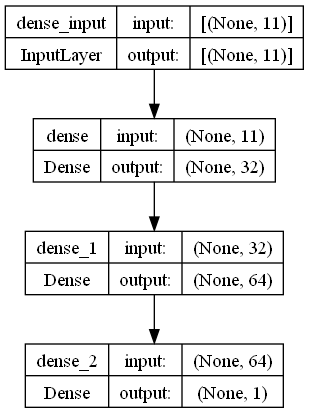

In [11]:
tf.keras.utils.plot_model(model_relu_64, show_shapes=True, to_file="model_relu_64.png")

In [12]:
num_epochs = 1000

th = model_relu_64.fit(x_train, 
                      y_train,
                      validation_split=0.2,
                      batch_size=128,
                      epochs=num_epochs)

Epoch 1/1000
7/7 [==============================] - 1s 48ms/step - loss: 325452032.0000 - mse: 325452032.0000 - mae: 13517.9395 - val_loss: 310340576.0000 - val_mse: 310340576.0000 - val_mae: 12654.4863
Epoch 2/1000
7/7 [==============================] - 0s 24ms/step - loss: 325438720.0000 - mse: 325438720.0000 - mae: 13517.4482 - val_loss: 310326784.0000 - val_mse: 310326784.0000 - val_mae: 12653.9600
Epoch 3/1000
7/7 [==============================] - 0s 21ms/step - loss: 325423520.0000 - mse: 325423520.0000 - mae: 13516.9092 - val_loss: 310310816.0000 - val_mse: 310310816.0000 - val_mae: 12653.3535
Epoch 4/1000
7/7 [==============================] - 0s 16ms/step - loss: 325405728.0000 - mse: 325405728.0000 - mae: 13516.2607 - val_loss: 310291232.0000 - val_mse: 310291232.0000 - val_mae: 12652.6123
Epoch 5/1000
7/7 [==============================] - 0s 17ms/step - loss: 325383840.0000 - mse: 325383840.0000 - mae: 13515.4600 - val_loss: 310266880.0000 - val_mse: 310266880.0000 - val_m

7/7 [==============================] - 0s 18ms/step - loss: 197455056.0000 - mse: 197455056.0000 - mae: 8582.2256 - val_loss: 187379136.0000 - val_mse: 187379136.0000 - val_mae: 7913.9780
Epoch 82/1000
7/7 [==============================] - 0s 18ms/step - loss: 194516816.0000 - mse: 194516816.0000 - mae: 8477.7822 - val_loss: 184601584.0000 - val_mse: 184601584.0000 - val_mae: 7827.6641
Epoch 83/1000
7/7 [==============================] - 0s 17ms/step - loss: 191614976.0000 - mse: 191614976.0000 - mae: 8373.9297 - val_loss: 181865392.0000 - val_mse: 181865392.0000 - val_mae: 7747.8101
Epoch 84/1000
7/7 [==============================] - 0s 19ms/step - loss: 188677520.0000 - mse: 188677520.0000 - mae: 8272.1973 - val_loss: 179222736.0000 - val_mse: 179222752.0000 - val_mae: 7668.3237
Epoch 85/1000
7/7 [==============================] - 0s 20ms/step - loss: 185882112.0000 - mse: 185882112.0000 - mae: 8178.1553 - val_loss: 176601776.0000 - val_mse: 176601776.0000 - val_mae: 7591.6001
Epoc

7/7 [==============================] - 0s 20ms/step - loss: 103058712.0000 - mse: 103058712.0000 - mae: 7978.3018 - val_loss: 101821984.0000 - val_mse: 101821984.0000 - val_mae: 7677.8970
Epoch 162/1000
7/7 [==============================] - 0s 22ms/step - loss: 102606152.0000 - mse: 102606152.0000 - mae: 7969.1016 - val_loss: 101423192.0000 - val_mse: 101423192.0000 - val_mae: 7670.0723
Epoch 163/1000
7/7 [==============================] - 0s 22ms/step - loss: 102156424.0000 - mse: 102156424.0000 - mae: 7956.5303 - val_loss: 101036320.0000 - val_mse: 101036320.0000 - val_mae: 7658.9531
Epoch 164/1000
7/7 [==============================] - 0s 21ms/step - loss: 101725040.0000 - mse: 101725040.0000 - mae: 7944.4751 - val_loss: 100635272.0000 - val_mse: 100635272.0000 - val_mae: 7649.2588
Epoch 165/1000
7/7 [==============================] - 0s 20ms/step - loss: 101301888.0000 - mse: 101301888.0000 - mae: 7934.6250 - val_loss: 100238672.0000 - val_mse: 100238672.0000 - val_mae: 7642.4248


7/7 [==============================] - 0s 22ms/step - loss: 71001416.0000 - mse: 71001416.0000 - mae: 6542.3340 - val_loss: 71400640.0000 - val_mse: 71400640.0000 - val_mae: 6357.3799
Epoch 244/1000
7/7 [==============================] - 0s 22ms/step - loss: 70635248.0000 - mse: 70635248.0000 - mae: 6521.9399 - val_loss: 71033560.0000 - val_mse: 71033560.0000 - val_mae: 6337.9116
Epoch 245/1000
7/7 [==============================] - 0s 22ms/step - loss: 70264536.0000 - mse: 70264536.0000 - mae: 6500.9292 - val_loss: 70662944.0000 - val_mse: 70662944.0000 - val_mae: 6318.5488
Epoch 246/1000
7/7 [==============================] - 0s 19ms/step - loss: 69897696.0000 - mse: 69897696.0000 - mae: 6480.4434 - val_loss: 70297440.0000 - val_mse: 70297440.0000 - val_mae: 6299.1157
Epoch 247/1000
7/7 [==============================] - 0s 19ms/step - loss: 69528224.0000 - mse: 69528224.0000 - mae: 6459.5449 - val_loss: 69925448.0000 - val_mse: 69925448.0000 - val_mae: 6278.5991
Epoch 248/1000
7/7 [

7/7 [==============================] - 0s 20ms/step - loss: 45484868.0000 - mse: 45484868.0000 - mae: 5118.5835 - val_loss: 45094524.0000 - val_mse: 45094520.0000 - val_mae: 4875.9990
Epoch 326/1000
7/7 [==============================] - 0s 22ms/step - loss: 45280576.0000 - mse: 45280576.0000 - mae: 5100.0815 - val_loss: 44861552.0000 - val_mse: 44861552.0000 - val_mae: 4858.2686
Epoch 327/1000
7/7 [==============================] - 0s 22ms/step - loss: 45075888.0000 - mse: 45075888.0000 - mae: 5087.1875 - val_loss: 44627188.0000 - val_mse: 44627188.0000 - val_mae: 4847.1724
Epoch 328/1000
7/7 [==============================] - 0s 21ms/step - loss: 44865748.0000 - mse: 44865740.0000 - mae: 5075.9053 - val_loss: 44400900.0000 - val_mse: 44400900.0000 - val_mae: 4830.6621
Epoch 329/1000
7/7 [==============================] - 0s 22ms/step - loss: 44667068.0000 - mse: 44667068.0000 - mae: 5062.2856 - val_loss: 44179844.0000 - val_mse: 44179844.0000 - val_mae: 4813.9453
Epoch 330/1000
7/7 [

7/7 [==============================] - 0s 21ms/step - loss: 37307900.0000 - mse: 37307900.0000 - mae: 4293.7173 - val_loss: 35278100.0000 - val_mse: 35278100.0000 - val_mae: 3949.0918
Epoch 408/1000
7/7 [==============================] - 0s 30ms/step - loss: 37275496.0000 - mse: 37275496.0000 - mae: 4284.9004 - val_loss: 35244936.0000 - val_mse: 35244936.0000 - val_mae: 3944.7292
Epoch 409/1000
7/7 [==============================] - 0s 47ms/step - loss: 37248024.0000 - mse: 37248024.0000 - mae: 4281.8945 - val_loss: 35199528.0000 - val_mse: 35199528.0000 - val_mae: 3943.7446
Epoch 410/1000
7/7 [==============================] - 0s 28ms/step - loss: 37219996.0000 - mse: 37219996.0000 - mae: 4280.0107 - val_loss: 35161456.0000 - val_mse: 35161456.0000 - val_mae: 3940.8792
Epoch 411/1000
7/7 [==============================] - 0s 28ms/step - loss: 37197100.0000 - mse: 37197100.0000 - mae: 4276.9165 - val_loss: 35122940.0000 - val_mse: 35122940.0000 - val_mae: 3934.9741
Epoch 412/1000
7/7 [

7/7 [==============================] - 0s 22ms/step - loss: 35921576.0000 - mse: 35921576.0000 - mae: 4062.9045 - val_loss: 33696228.0000 - val_mse: 33696228.0000 - val_mae: 3759.1516
Epoch 490/1000
7/7 [==============================] - 0s 24ms/step - loss: 35904884.0000 - mse: 35904884.0000 - mae: 4060.0842 - val_loss: 33688544.0000 - val_mse: 33688544.0000 - val_mae: 3758.6052
Epoch 491/1000
7/7 [==============================] - 0s 20ms/step - loss: 35897976.0000 - mse: 35897976.0000 - mae: 4055.9675 - val_loss: 33688164.0000 - val_mse: 33688164.0000 - val_mae: 3755.5735
Epoch 492/1000
7/7 [==============================] - 0s 20ms/step - loss: 35878672.0000 - mse: 35878672.0000 - mae: 4054.3689 - val_loss: 33667900.0000 - val_mse: 33667900.0000 - val_mae: 3756.8188
Epoch 493/1000
7/7 [==============================] - 0s 24ms/step - loss: 35863820.0000 - mse: 35863820.0000 - mae: 4054.4082 - val_loss: 33652532.0000 - val_mse: 33652532.0000 - val_mae: 3756.2739
Epoch 494/1000
7/7 [

7/7 [==============================] - 0s 20ms/step - loss: 34749828.0000 - mse: 34749828.0000 - mae: 3950.8484 - val_loss: 32622618.0000 - val_mse: 32622618.0000 - val_mae: 3685.0061
Epoch 572/1000
7/7 [==============================] - 0s 21ms/step - loss: 34733768.0000 - mse: 34733768.0000 - mae: 3949.6313 - val_loss: 32598840.0000 - val_mse: 32598840.0000 - val_mae: 3685.1887
Epoch 573/1000
7/7 [==============================] - 0s 21ms/step - loss: 34716840.0000 - mse: 34716836.0000 - mae: 3950.4438 - val_loss: 32585440.0000 - val_mse: 32585440.0000 - val_mae: 3686.0164
Epoch 574/1000
7/7 [==============================] - 0s 21ms/step - loss: 34700872.0000 - mse: 34700872.0000 - mae: 3948.6917 - val_loss: 32569574.0000 - val_mse: 32569574.0000 - val_mae: 3683.4187
Epoch 575/1000
7/7 [==============================] - 0s 21ms/step - loss: 34688872.0000 - mse: 34688872.0000 - mae: 3947.4817 - val_loss: 32545214.0000 - val_mse: 32545214.0000 - val_mae: 3683.9065
Epoch 576/1000
7/7 [

7/7 [==============================] - 0s 20ms/step - loss: 33349608.0000 - mse: 33349608.0000 - mae: 3838.9355 - val_loss: 31194290.0000 - val_mse: 31194290.0000 - val_mae: 3590.8376
Epoch 654/1000
7/7 [==============================] - 0s 20ms/step - loss: 33332326.0000 - mse: 33332326.0000 - mae: 3840.3926 - val_loss: 31172428.0000 - val_mse: 31172428.0000 - val_mae: 3591.0898
Epoch 655/1000
7/7 [==============================] - 0s 22ms/step - loss: 33316254.0000 - mse: 33316254.0000 - mae: 3839.4597 - val_loss: 31145980.0000 - val_mse: 31145980.0000 - val_mae: 3588.6296
Epoch 656/1000
7/7 [==============================] - 0s 22ms/step - loss: 33297108.0000 - mse: 33297108.0000 - mae: 3837.2341 - val_loss: 31125816.0000 - val_mse: 31125816.0000 - val_mae: 3587.5947
Epoch 657/1000
7/7 [==============================] - 0s 21ms/step - loss: 33280526.0000 - mse: 33280526.0000 - mae: 3835.2490 - val_loss: 31109254.0000 - val_mse: 31109254.0000 - val_mae: 3583.9004
Epoch 658/1000
7/7 [

7/7 [==============================] - 0s 22ms/step - loss: 31660164.0000 - mse: 31660164.0000 - mae: 3669.6531 - val_loss: 29456312.0000 - val_mse: 29456312.0000 - val_mae: 3429.6321
Epoch 736/1000
7/7 [==============================] - 0s 19ms/step - loss: 31636528.0000 - mse: 31636528.0000 - mae: 3663.3523 - val_loss: 29439124.0000 - val_mse: 29439124.0000 - val_mae: 3425.8188
Epoch 737/1000
7/7 [==============================] - 0s 20ms/step - loss: 31614752.0000 - mse: 31614752.0000 - mae: 3660.3003 - val_loss: 29415524.0000 - val_mse: 29415524.0000 - val_mae: 3423.8618
Epoch 738/1000
7/7 [==============================] - 0s 19ms/step - loss: 31593374.0000 - mse: 31593374.0000 - mae: 3661.3333 - val_loss: 29388322.0000 - val_mse: 29388322.0000 - val_mae: 3425.1819
Epoch 739/1000
7/7 [==============================] - 0s 20ms/step - loss: 31567876.0000 - mse: 31567876.0000 - mae: 3659.1531 - val_loss: 29371000.0000 - val_mse: 29371000.0000 - val_mae: 3422.0339
Epoch 740/1000
7/7 [

7/7 [==============================] - 0s 23ms/step - loss: 29838838.0000 - mse: 29838838.0000 - mae: 3490.9402 - val_loss: 27634140.0000 - val_mse: 27634140.0000 - val_mae: 3263.8450
Epoch 818/1000
7/7 [==============================] - 0s 23ms/step - loss: 29815568.0000 - mse: 29815568.0000 - mae: 3487.8599 - val_loss: 27615740.0000 - val_mse: 27615740.0000 - val_mae: 3262.8821
Epoch 819/1000
7/7 [==============================] - 0s 22ms/step - loss: 29801448.0000 - mse: 29801448.0000 - mae: 3489.3762 - val_loss: 27583752.0000 - val_mse: 27583752.0000 - val_mae: 3265.2803
Epoch 820/1000
7/7 [==============================] - 0s 22ms/step - loss: 29774348.0000 - mse: 29774348.0000 - mae: 3486.7419 - val_loss: 27580298.0000 - val_mse: 27580298.0000 - val_mae: 3261.2764
Epoch 821/1000
7/7 [==============================] - 0s 21ms/step - loss: 29757316.0000 - mse: 29757316.0000 - mae: 3480.4351 - val_loss: 27574228.0000 - val_mse: 27574228.0000 - val_mae: 3254.4438
Epoch 822/1000
7/7 [

7/7 [==============================] - 0s 37ms/step - loss: 28163136.0000 - mse: 28163136.0000 - mae: 3336.9126 - val_loss: 26038402.0000 - val_mse: 26038402.0000 - val_mae: 3144.4541
Epoch 900/1000
7/7 [==============================] - 0s 33ms/step - loss: 28145016.0000 - mse: 28145016.0000 - mae: 3332.5669 - val_loss: 26028386.0000 - val_mse: 26028386.0000 - val_mae: 3142.8452
Epoch 901/1000
7/7 [==============================] - 0s 29ms/step - loss: 28126236.0000 - mse: 28126236.0000 - mae: 3329.2922 - val_loss: 26013088.0000 - val_mse: 26013088.0000 - val_mae: 3139.2244
Epoch 902/1000
7/7 [==============================] - 0s 27ms/step - loss: 28111212.0000 - mse: 28111212.0000 - mae: 3329.9895 - val_loss: 25976100.0000 - val_mse: 25976100.0000 - val_mae: 3142.3972
Epoch 903/1000
7/7 [==============================] - 0s 28ms/step - loss: 28089990.0000 - mse: 28089990.0000 - mae: 3329.4417 - val_loss: 25963912.0000 - val_mse: 25963912.0000 - val_mae: 3139.4924
Epoch 904/1000
7/7 [

7/7 [==============================] - 0s 23ms/step - loss: 26778872.0000 - mse: 26778872.0000 - mae: 3206.4783 - val_loss: 24761656.0000 - val_mse: 24761656.0000 - val_mae: 3064.5117
Epoch 982/1000
7/7 [==============================] - 0s 21ms/step - loss: 26762264.0000 - mse: 26762264.0000 - mae: 3202.4436 - val_loss: 24752312.0000 - val_mse: 24752312.0000 - val_mae: 3062.7922
Epoch 983/1000
7/7 [==============================] - 0s 22ms/step - loss: 26750786.0000 - mse: 26750786.0000 - mae: 3204.6831 - val_loss: 24715772.0000 - val_mse: 24715772.0000 - val_mae: 3068.2139
Epoch 984/1000
7/7 [==============================] - 0s 21ms/step - loss: 26734554.0000 - mse: 26734554.0000 - mae: 3208.8269 - val_loss: 24699408.0000 - val_mse: 24699408.0000 - val_mae: 3067.7390
Epoch 985/1000
7/7 [==============================] - 0s 22ms/step - loss: 26718830.0000 - mse: 26718830.0000 - mae: 3204.3066 - val_loss: 24691890.0000 - val_mse: 24691890.0000 - val_mae: 3063.2659
Epoch 986/1000
7/7 [

In [13]:
th.history.keys()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])

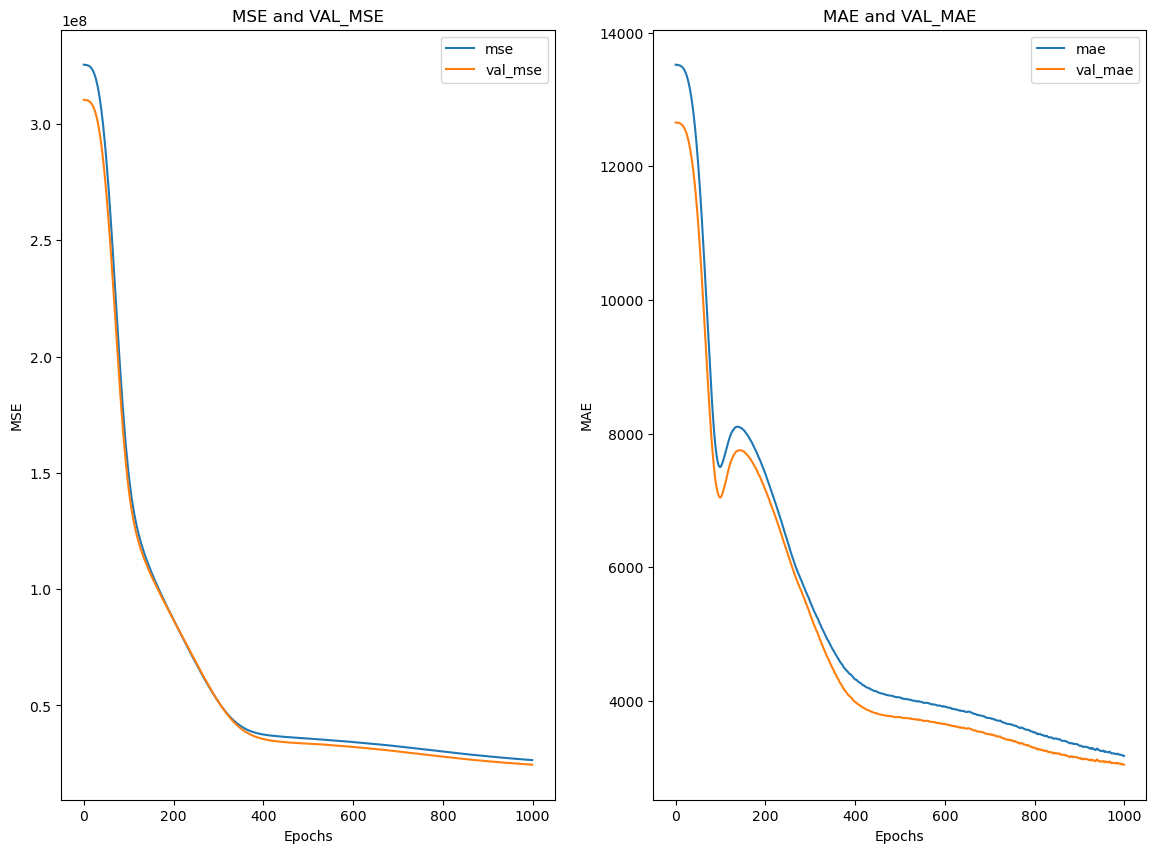

In [21]:
plt.figure(figsize=[14, 10])

plt.subplot(1, 2, 1)

plt.plot(range(num_epochs), np.array(th.history["mse"]))
plt.plot(range(num_epochs), np.array(th.history["val_mse"]))
plt.title("MSE and VAL_MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(["mse", "val_mse"])

plt.subplot(1, 2, 2)

plt.plot(range(num_epochs), np.array(th.history["mae"]))
plt.plot(range(num_epochs), np.array(th.history["val_mae"]))
plt.title("MAE and VAL_MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend(["mae", "val_mae"])

plt.show()

# np.array(th.history["mse"]).shape

In [22]:
model_relu_64.evaluate(x_train, y_train)

34/34 [==============================] - 0s 1ms/step - loss: 26095216.0000 - mse: 26095216.0000 - mae: 3148.5886


[26095216.0, 26095216.0, 3148.588623046875]

In [23]:
y_pred = model_relu_64.predict(x_test)

r2_score(y_test, y_pred)

9/9 [==============================] - 0s 2ms/step


0.859224484019151

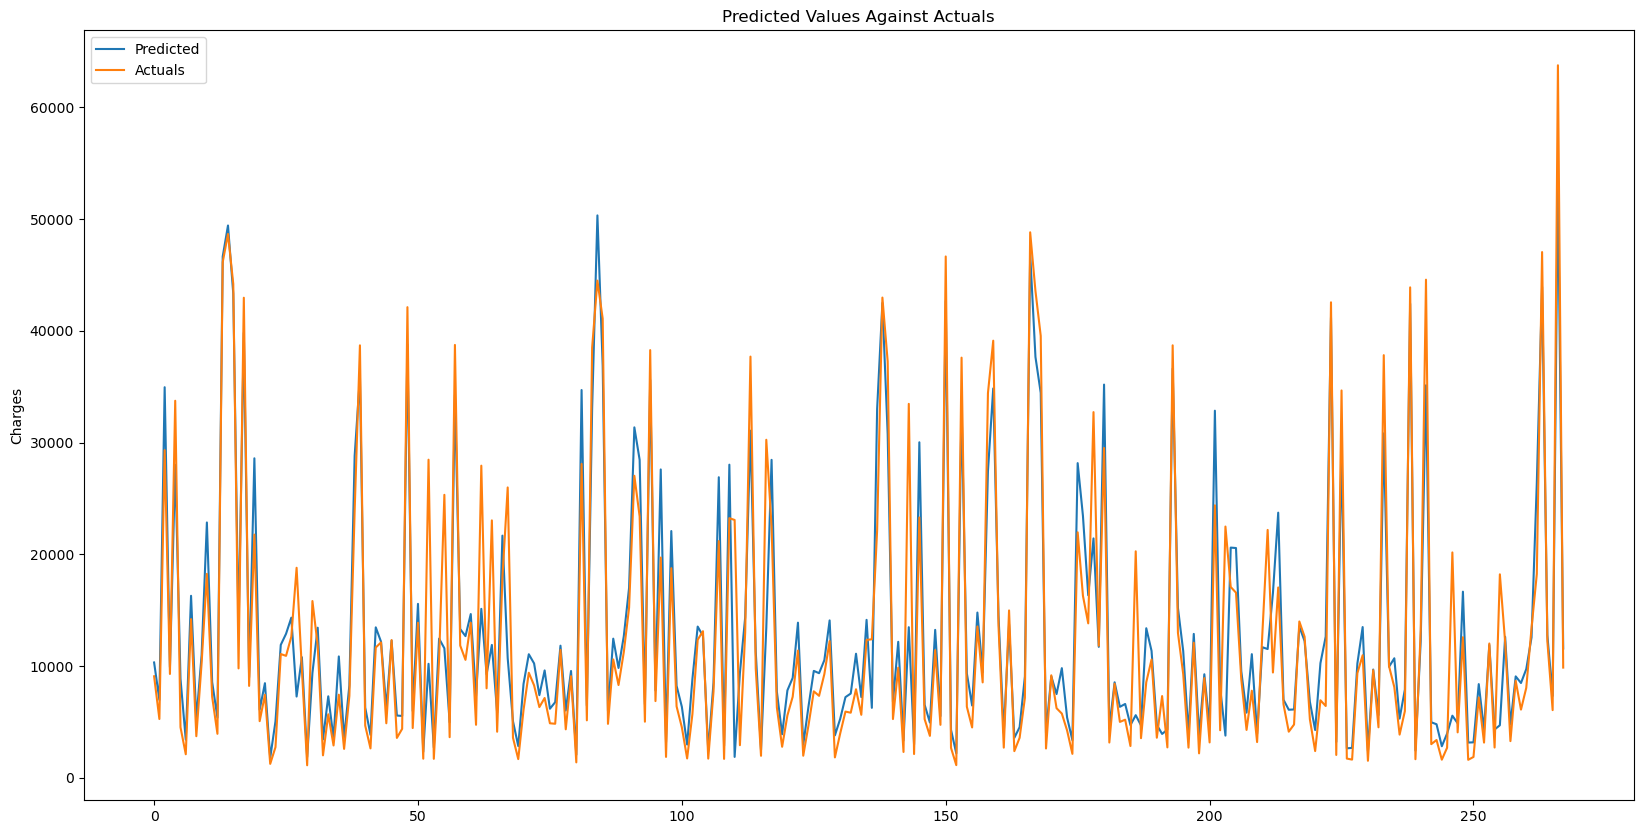

In [27]:
plt.figure(figsize=[20, 10])

plt.plot(y_pred)
plt.plot(y_test.values)

plt.title("Predicted Values Against Actuals")
plt.ylabel("Charges")
plt.legend(["Predicted", "Actuals"])
plt.show()

In [28]:
pred_result = pd.DataFrame({"y_true": y_test.values.flatten(),
                           "y_pred": y_pred.flatten()}, index=range(len(y_pred)))

pred_result.sample(10)

,y_true,y_pred
187,3554.20300,4704.551758
147,3761.29200,4953.489258
74,7152.67140,9621.245117
204,17085.26760,20610.343750
4,33750.29180,28017.845703
192,2731.91220,4324.354492
172,5757.41345,9821.254883
58,11848.14100,13323.944336
171,6238.29800,7505.564453
206,8827.20990,9553.143555


In [30]:
from sklearn.metrics import mean_squared_error
import math

mse_charges = mean_squared_error(y_test, y_pred)

math.sqrt(mse_charges)

4674.956714358615

In [31]:
model_relu_64.save("../my_models/model_relu_64")

INFO:tensorflow:Assets written to: ../my_models/model_relu_64\assets


INFO:tensorflow:Assets written to: ../my_models/model_relu_64\assets
